【作业4内容】 

作业4-1： 基于提供的心脏CTA数据，利用形态学算子实现肺部血管的滤除； 

作业4-2： 基于提供的心脏CTA数据以及心脏各部分标签，实现基于多模板配准的心腔分割算法；

1. 数据集结构
数据集源于 MM-WHS（全心脏子结构分割任务），压缩包内一共有三种类型的数据，内容看起来同名文件是一样的，只是保存的格式上存在差异，为了更方便的处理可以选择已经预处理好的 nii 文件来做，其他两类数据可以忽略。
1. 数据类别
在 nii 系列文件中，每个 ct_train_A_B.nii 文件中相同 A 编号的数据属于同一个，而 B 一共有 9 个类别【Ao, Heart, imageROI, LA, LV, LV_Myo. PA, RA, RV】。其中 imageROI 是图像本身，而其余 8 个文件是该数据不同区域的分割标签。
1. 任务目标
利用配准的算法，实现分割的目标。比如我现在取 1~9 号数据作为模板，10 号数据作为待分割标签。那么我首先将 10 号图像和 1 号数据进行一次配准，可以得到一个从 1 号数据配准到 10 号数据的配准场，该配准场如果我对 1 号数据的 8 个标签都运用一遍，就能得到 8 个形变后的标签，该标签在一定程度上跟 10 号图像的标签近似。为了进一步提高准确性，我将上述过程重复运用在 2~9 号数据与标签上，这样就得到了一共 9 组配准后的近似标签。最后我们将这 9 组标签通过平均或者最大或者其他你觉得更好的方式来融合，从而得到最终的标签目标，该结果就是通过 atlas 方法实现的对 10 号数据的分割结果。

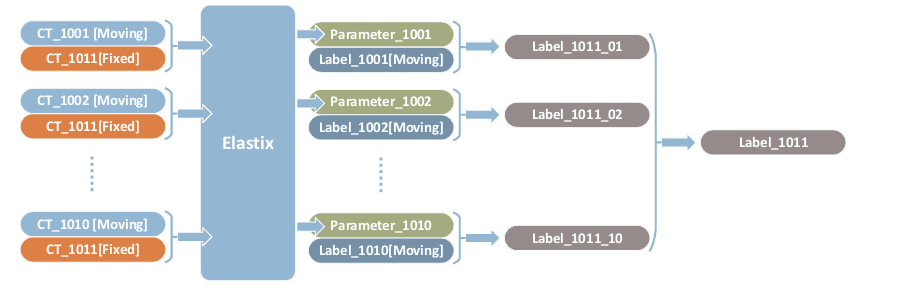

根据文件名，这些文件似乎是心脏 CTA（Computed Tomography Angiography，计算机断层扫描血管成像）数据，包含心脏及其周围结构的图像和分割结果。以下是各文件的作用解释：

ct_train_1001_Ao.nii：主动脉（Aorta）的分割结果，格式为 NIfTI。

ct_train_1001_Heart.nii：心脏整体的分割结果，格式为 NIfTI。

ct_train_1001_imageROI.mhd：心脏区域的原始图像数据，格式为 MetaImage（.mhd 文件通常与 .raw 文件配套使用）。

ct_train_1001_imageROI.nii：心脏区域的原始图像数据，格式为 NIfTI。

ct_train_1001_imageROI.raw：心脏区域的原始图像数据，格式为原始二进制数据（通常与 .mhd 文件配套使用）。

ct_train_1001_LA.nii：左心房（Left Atrium）的分割结果，格式为 NIfTI。

ct_train_1001_LV.nii：左心室（Left Ventricle）的分割结果，格式为 NIfTI。

ct_train_1001_LV_Myo.nii：左心室心肌（Left Ventricle Myocardium）的分割结果，格式为 NIfTI。

ct_train_1001_PA.nii：肺动脉（Pulmonary Artery）的分割结果，格式为 NIfTI。

ct_train_1001_RA.nii：右心房（Right Atrium）的分割结果，格式为 NIfTI。

ct_train_1001_RV.nii：右心室（Right Ventricle）的分割结果，格式为 NIfTI。

ct_train_1002_* 等文件：其他患者（如 1002、1003 等）的对应数据。

In [ ]:
import nibabel as nib
import numpy as np
from scipy.ndimage import binary_opening,binary_erosion
from skimage.morphology import ball
import matplotlib.pyplot as plt
import os
from skimage.measure import find_contours  # 用于检测轮廓

In [6]:
# 设置字体为宋体
plt.rcParams['font.sans-serif'] = ['SimSun']  # 使用宋体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [3]:
# 加载 NIfTI 文件
folder_path = r'C:\Users\coactor\Desktop\visual data\VSCode\VS-C\Local\ct_atlas' 
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):
        print(file_name)

ct_train_1001_Ao.nii
ct_train_1001_Heart.nii
ct_train_1001_imageROI.mhd
ct_train_1001_imageROI.nii
ct_train_1001_imageROI.raw
ct_train_1001_LA.nii
ct_train_1001_LV.nii
ct_train_1001_LV_Myo.nii
ct_train_1001_PA.nii
ct_train_1001_RA.nii
ct_train_1001_RV.nii
ct_train_1002_Ao.nii
ct_train_1002_Heart.nii
ct_train_1002_imageROI.mhd
ct_train_1002_imageROI.nii
ct_train_1002_imageROI.raw
ct_train_1002_LA.nii
ct_train_1002_LV.nii
ct_train_1002_LV_Myo.nii
ct_train_1002_PA.nii
ct_train_1002_RA.nii
ct_train_1002_RV.nii
ct_train_1003_Ao.nii
ct_train_1003_Heart.nii
ct_train_1003_imageROI.mhd
ct_train_1003_imageROI.nii
ct_train_1003_imageROI.raw
ct_train_1003_LA.nii
ct_train_1003_LV.nii
ct_train_1003_LV_Myo.nii
ct_train_1003_PA.nii
ct_train_1003_RA.nii
ct_train_1003_RV.nii
ct_train_1004_Ao.nii
ct_train_1004_Heart.nii
ct_train_1004_imageROI.mhd
ct_train_1004_imageROI.nii
ct_train_1004_imageROI.raw
ct_train_1004_LA.nii
ct_train_1004_LV.nii
ct_train_1004_LV_Myo.nii
ct_train_1004_PA.nii
ct_train_1004_RA.n

In [ ]:


def remove_pulmonary_artery(num, data_folder, result_folder):
    """
    滤除指定病例的肺动脉（PA），并标记差异
    """
    # 1. 加载数据
    image_path = os.path.join(data_folder, f'ct_train_{num}_imageROI.nii')
    pa_mask_path = os.path.join(data_folder, f'ct_train_{num}_PA.nii')
    
    img = nib.load(image_path)
    data = img.get_fdata().astype(np.float64)
    pa_mask = nib.load(pa_mask_path).get_fdata().astype(bool)
    
    # 2. 形态学优化肺动脉掩码
    selem = ball(radius=1)
    pa_mask_eroded = binary_erosion(pa_mask, structure=selem)
    
    # 3. 滤除肺动脉区域
    filtered_data = data.copy()
    filtered_data[pa_mask_eroded] = 0
    
    # 4. 保存结果
    result_img = nib.Nifti1Image(filtered_data, img.affine)
    os.makedirs(result_folder, exist_ok=True)
    nib.save(result_img, os.path.join(result_folder, f'ct_train_{num}_imageROI_no_PA.nii'))
    
    # 5. 可视化：选择差异最大的切片并标记
    slice_idx = find_most_significant_slice(pa_mask_eroded)  # 自动选择关键切片
    show_comparison_with_markers(data, pa_mask_eroded, filtered_data, num, slice_idx)
    
    print(f"病例 {num} 的肺动脉滤除完成！")

def find_most_significant_slice(pa_mask):
    """
    找到肺动脉掩码中体积最大的切片（差异最明显）
    """
    # 沿轴向（假设为第3维）统计每层掩码的像素数
    mask_sum = np.sum(pa_mask, axis=(0, 1))
    return np.argmax(mask_sum)  # 返回掩码最大的切片索引

def show_comparison_with_markers(original, pa_mask, filtered, num, slice_idx):
    """
    可视化并标记差异
    """
    # 提取指定切片
    original_slice = original[:, :, slice_idx]
    filtered_slice = filtered[:, :, slice_idx]
    pa_mask_slice = pa_mask[:, :, slice_idx]
    
    # 检测肺动脉区域的轮廓
    contours = find_contours(pa_mask_slice, 0.5)  # 找到轮廓坐标
    
    # 创建画布
    plt.figure(figsize=(15, 5))
    
    # 1. 原始图像
    plt.subplot(1, 3, 1)
    plt.imshow(original_slice, cmap='gray')
    plt.title(f'原始图像 (Case {num})\n切片: {slice_idx}')
    plt.axis('off')
    
    # 2. 滤除后的图像 + 标记差异
    plt.subplot(1, 3, 2)
    plt.imshow(filtered_slice, cmap='gray')
    # 绘制肺动脉轮廓（红色）
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')  # 注意坐标轴交换
    plt.title('滤除肺动脉后的图像（红色为移除区域）')
    plt.axis('off')
    
    # 3. 差异叠加图（半透明显示肺动脉区域）
    plt.subplot(1, 3, 3)
    plt.imshow(filtered_slice, cmap='gray')
    plt.imshow(pa_mask_slice, cmap='Reds', alpha=0.3)  # 半透明叠加
    plt.title('差异区域叠加')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


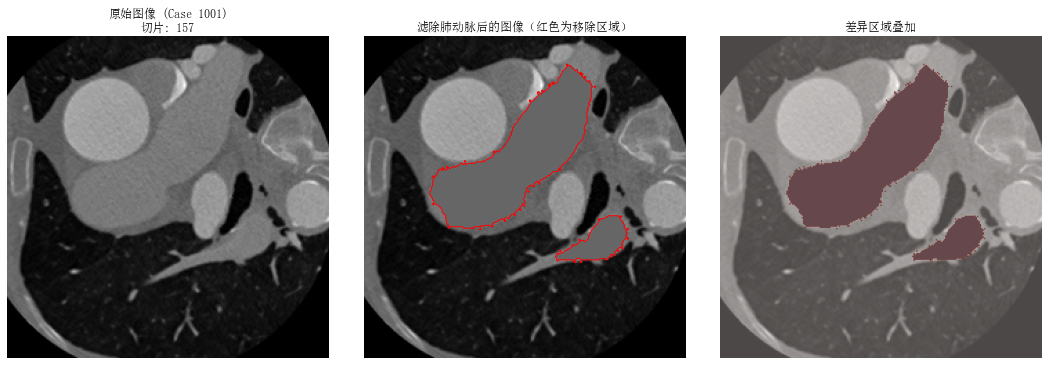

病例 1001 的肺动脉滤除完成！


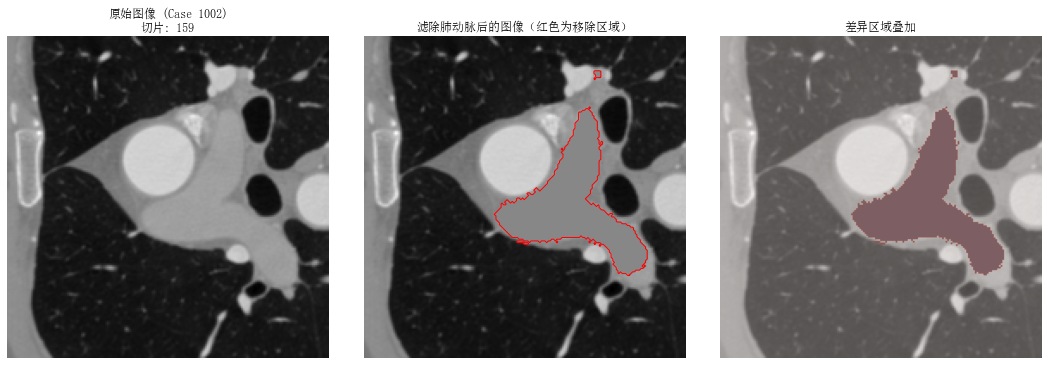

病例 1002 的肺动脉滤除完成！


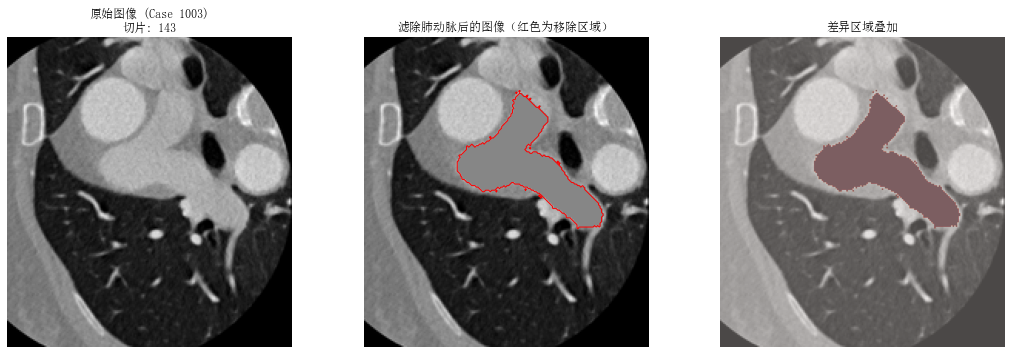

病例 1003 的肺动脉滤除完成！


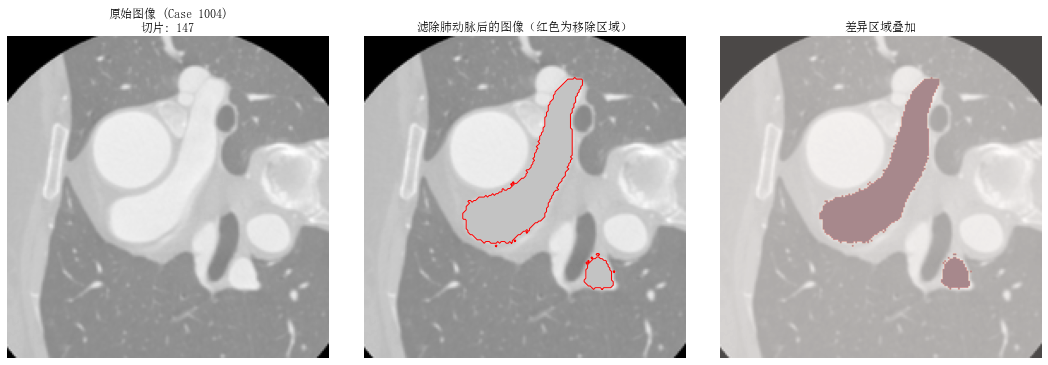

病例 1004 的肺动脉滤除完成！


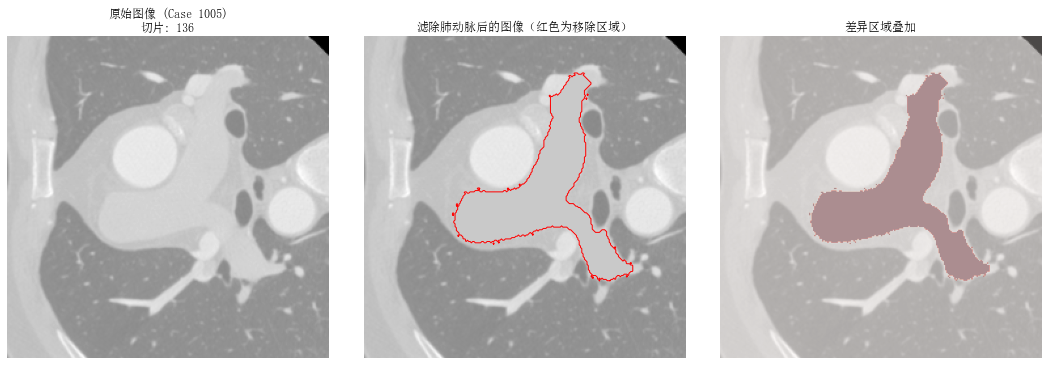

病例 1005 的肺动脉滤除完成！


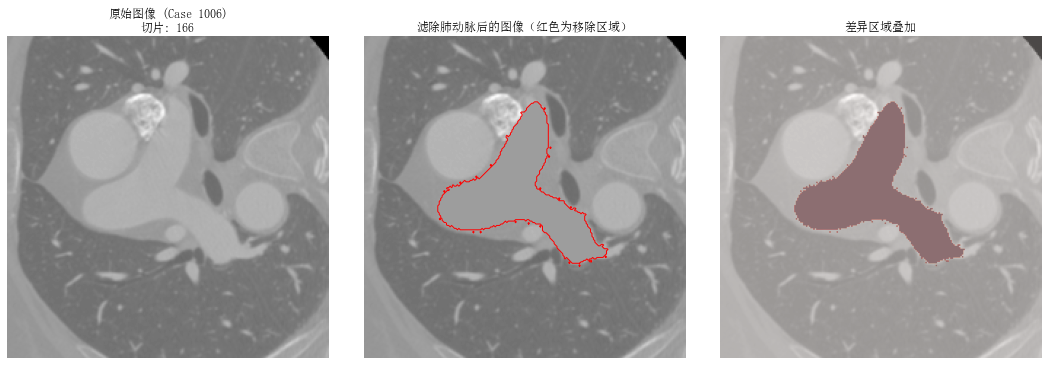

病例 1006 的肺动脉滤除完成！


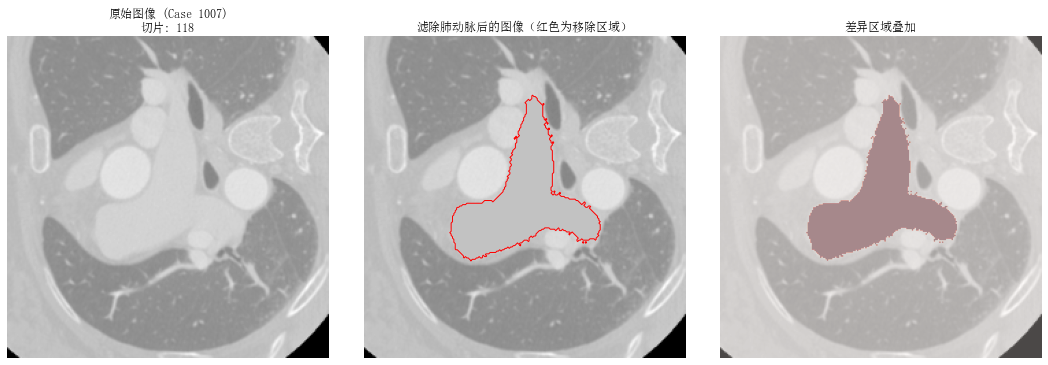

病例 1007 的肺动脉滤除完成！


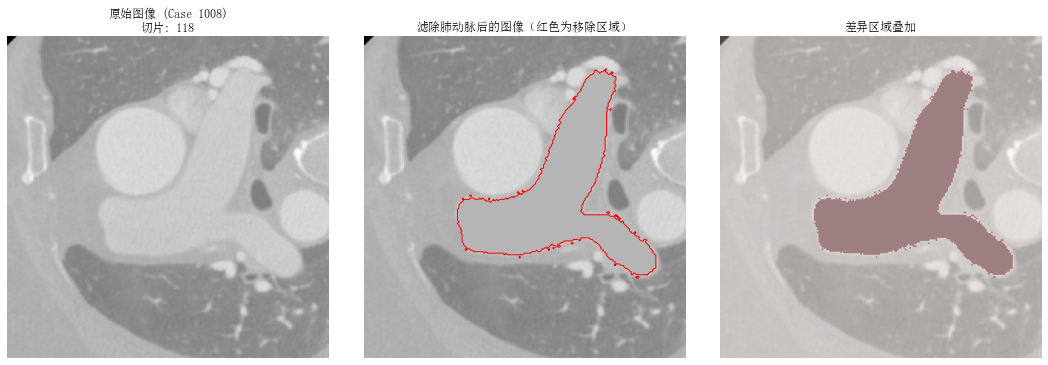

病例 1008 的肺动脉滤除完成！


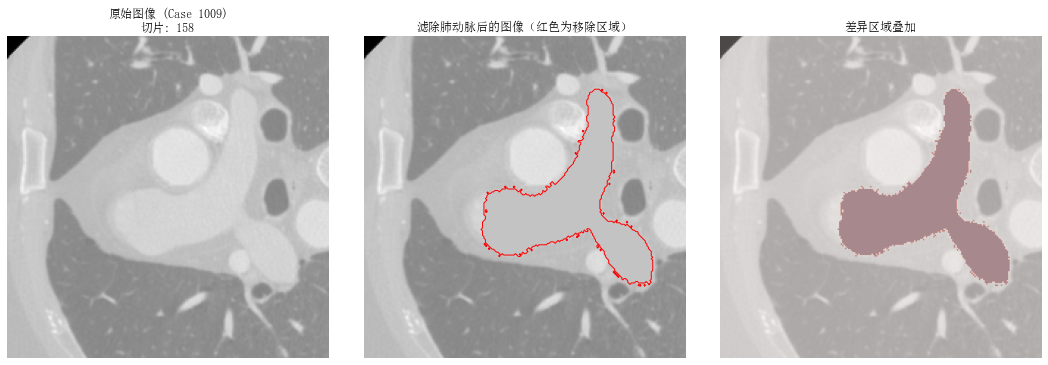

病例 1009 的肺动脉滤除完成！


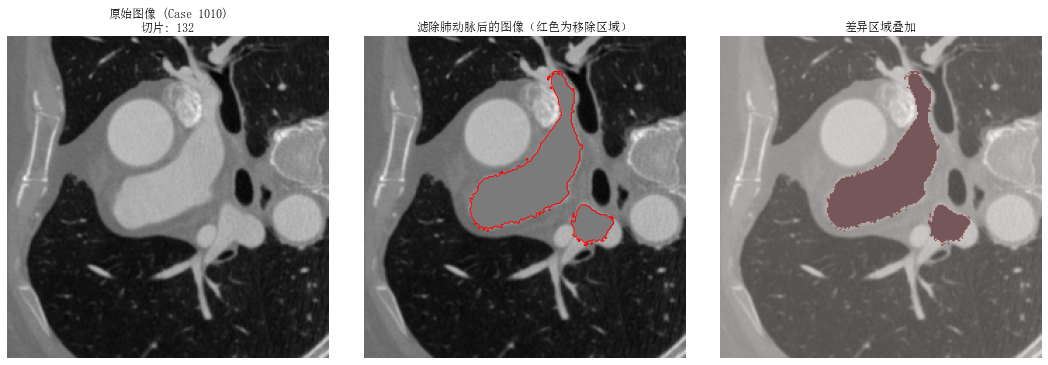

病例 1010 的肺动脉滤除完成！


In [ ]:
data_folder = r'C:\Users\coactor\Desktop\visual data\VSCode\VS-C\Local\ct_atlas' # 数据文件夹路径
result_folder = r'C:\Users\coactor\Desktop\visual data\VSCode\VS-C\Local\ct_atlas\result' # 结果保存路径
# 处理病例 1001 到 1010
for num in range(1001, 1011):
    remove_pulmonary_artery(str(num), data_folder, result_folder)